# Кейс по моделированию

Данная домашняя работа выполняется в формате отчета (написание кода + свои размышления). Оценивается как правильность выполнения домашней работы (код), так и правильность объяснения действий и результатов. Data Scientist должен понимать, что он делает и почему он это делает. Также приходится объяснять свои размышления и принимаемое решение руководителю или человеку со стороны бизнеса.

Старайтесь выполнить домашку САМОСТОЯТЕЛЬНО. Это идет вам на пользу (Хорошая оценка - меньшее, что можно получить, главное - знания по результатам выполнения). Если что-то не получается, обращайтесь к преподавателю с вопросами.

Всего 23 балла. 10 из 10 - это 20 баллов. Лучше решить по максимуму с запасом.

Начнём!

### Данные

В задачах кредитного скоринга, предсказания дефолта самым важным признаком служит заработная плата клиента. Но... Не всегда она известна.

Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий, превысит ли средний заработок человека порог $50k

#### Как оценить качество алгоритма

Мы будем смотреть на показатель Area Under ROC Curve (ROC_AUC). Напомню, что он тем выше, чем мы правильнее упорядочиваем наши предсказанные "вероятности". Подробнее [здесь](https://ru.wikipedia.org/wiki/ROC-кривая)

#### Делаем важные импорты

In [1]:
import math
import pylab as pl
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

#### Данные

1) age (Возраст): continuous. 

2) workclass (Информация о работе): Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 

3) fnlwgt (Вещественный признак - анонимен): continuous. 

4) education (Образование): Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 

5) education-num: continuous. 

6) marital-status (Семейное положение): Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 

7) occupation (Род деятельности): Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 

8) relationship (Статус в семье): Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 

9) race (Раса): White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 

10) sex (Пол): Female, Male. 

11) capital-gain (Размер капитала): continuous. 

12) capital-loss (Фича на основе капитала): continuous. 

13) hours-per-week (Сколько часов в неделю работает): continuous.

14) >50K,<=50K (Ваш таргет)

#### Скачиваем данные

In [2]:
# В данной таблице NaNы заполнены значком '?' - заменим его на проспуски с помощью параметра "na_values"
data_adult = pd.read_csv("HW_ML_04-05_data.adult.csv", na_values='?')
data_adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


### 1. Анализ

Иногда в данных встречаются пропуски.

Более подробно о работе с пропусками в Pandas можно прочитать [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html) 

**(1 балл)** 
- Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

- Проведите анализ (количество строк, количество строк после удаления (use df.shape),...)

Выведем на экран количество строк до удаления объектов с пустыми значениями

In [3]:
data_adult.shape

(16280, 14)

Выведем на экран строки с пустыми значениями

In [4]:
data_adult[data_adult.isnull().any(axis=1)]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
7,18,NaN,423460,11th,7,Never-married,NaN,Own-child,White,Male,0,0,36,<=50K
29,77,NaN,152900,5th-6th,3,Married-civ-spouse,NaN,Husband,White,Male,0,0,20,<=50K
36,17,NaN,89870,10th,6,Never-married,NaN,Own-child,White,Male,0,0,40,<=50K
38,76,NaN,431192,7th-8th,4,Widowed,NaN,Not-in-family,White,Male,0,0,2,<=50K
69,36,NaN,389850,HS-grad,9,Married-spouse-absent,NaN,Unmarried,Black,Male,0,0,50,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16188,64,NaN,196288,Assoc-acdm,12,Never-married,NaN,Not-in-family,White,Female,0,0,20,<=50K
16223,17,NaN,202521,11th,7,Never-married,NaN,Own-child,White,Male,0,0,40,<=50K
16239,19,NaN,169324,Some-college,10,Never-married,NaN,Own-child,White,Male,0,0,10,<=50K
16245,59,NaN,367984,Bachelors,13,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,<=50K


Удалим строки с пустыми значениями

In [5]:
data_adult = data_adult.dropna(axis=0)
data_adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,Local-gov,514716,Bachelors,13,Never-married,Adm-clerical,Own-child,Black,Female,0,0,40,<=50K
16276,32,Private,207668,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,45,>50K
16277,27,Private,104457,Bachelors,13,Never-married,Machine-op-inspct,Not-in-family,Asian-Pac-Islander,Male,0,0,40,<=50K
16278,59,State-gov,268700,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,<=50K


Выведем на экран количество строк после удаления объектов с пустыми значениями

In [6]:
data_adult.shape

(15347, 14)

**(1 балл)** 
- Выделите целевую переменную (наш таргет) в отдельную переменную (назовите ее 'target')
- Преобразуйте к бинарному формату ({0,1})
- Удалите из датасета старую переменную.
- Посмотрите распределение целевой переменной

Создадим целевую переменную target, в которую запишем столбец >50K,<=50K

In [7]:
target = data_adult['>50K,<=50K']
target

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4         >50K
         ...  
16275    <=50K
16276     >50K
16277    <=50K
16278    <=50K
16279     >50K
Name: >50K,<=50K, Length: 15347, dtype: object

Преобразуем target к бинарному формату ({0,1})

In [8]:
target = (target == '>50K') * 1
target.value_counts()

0    11407
1     3940
Name: >50K,<=50K, dtype: int64

Удалим из датасета переменную >50K,<=50K

In [9]:
data_adult = data_adult.drop(columns='>50K,<=50K') 
data_adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40


Посмотрим распределение целевой переменной при помощи круговой диаграммы (pie)

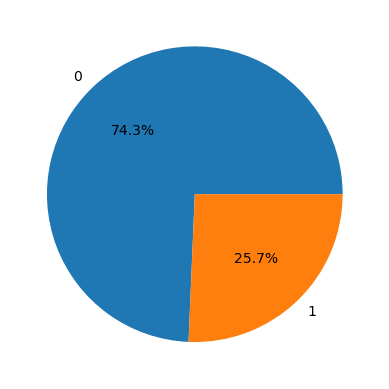

In [10]:
plt.pie(target.value_counts(), labels=['0', '1'], autopct = '%1.1f%%')
plt.show()

**(1 балл)**
- Постройте гистограмму распределения признака "capital-gain" с количеством бинов=50
- Посмотрите процентное соотношение категорий в колонке "workclass"

Построим гистограмму распределения признака "capital-gain" с количеством бинов=50

<AxesSubplot:>

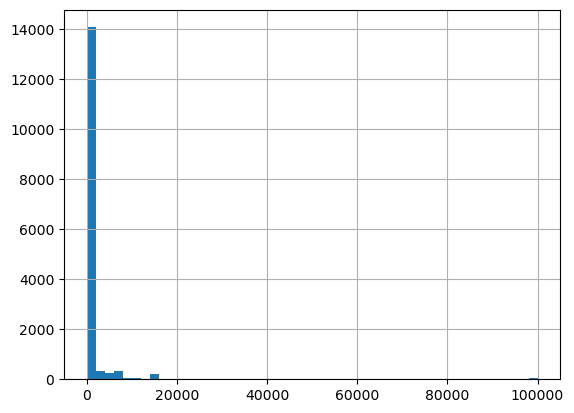

In [11]:
data_adult['capital-gain'].hist(bins=50)

Посмотрим процентное соотношение категорий в колонке "workclass"

In [12]:
data_adult['workclass'].value_counts(normalize=True) * 100

Private             73.512739
Self-emp-not-inc     8.627093
Local-gov            6.952499
State-gov            4.202776
Self-emp-inc         3.655438
Federal-gov          3.003844
Without-pay          0.045612
Name: workclass, dtype: float64

### 2. Категориальные признаки

Как вы могли заметить, среди признаков есть категориальные.

**(1 балл)**
- Выделите 3 переменные (cat - список категориальных признаков, num - список вещественных признаков, target - таргет (строка));
- Закодируйте категориальные признаки;
- Выберите признаки для обучения.

Чтобы понять, какие признаки категориальные, используйте:
- df.dtypes,
- df\[col\].value_counts,
- df\[col\].nunique
- ...

Для начала нужно узнать типы признаков, чтобы понять, какие относить к категориальным, какие к вещественным

In [13]:
data_adult.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
dtype: object

Далее посмотрим на количество уникальных значений в каждом столбце

In [14]:
data_adult.nunique()

age                  72
workclass             7
fnlwgt            12065
education            16
education-num        16
marital-status        7
occupation           14
relationship          6
race                  5
sex                   2
capital-gain        105
capital-loss         81
hours-per-week       92
dtype: int64

Переменная, отображающая пол человека, имеет 2 уникальных значения (бинарный формат). Преобразуем данную переменную в вещественный признак

In [15]:
data_adult['sex'] = data_adult['sex'].map({'Male': 1, 'Female': 0})

Выделим 3 переменные (cat - список категориальных признаков, num - список вещественных признаков, target - таргет (строка))

In [16]:
num = ['age', 'sex', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
cat = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
target = target

Далее закодируем категориальные признаки. Функция get_dummies не повлияет на вещественные признаки, поэтому аргументом функции будет весь датасет data_adult

In [17]:
data_adult = pd.get_dummies(data_adult)
data_adult

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,34,284843,9,1,594,0,60,0,1,0,...,1,0,0,0,0,0,0,1,0,0
1,40,190290,10,1,0,0,40,0,0,1,...,1,0,0,0,0,0,0,0,0,1
2,36,177858,13,1,0,0,40,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,22,184756,10,0,0,0,30,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,47,149700,13,1,15024,0,40,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,514716,13,0,0,0,40,0,1,0,...,0,0,1,0,0,0,0,1,0,0
16276,32,207668,13,1,15024,0,45,0,0,1,...,0,0,0,0,0,0,0,0,0,1
16277,27,104457,13,1,0,0,40,0,0,1,...,1,0,0,0,0,0,1,0,0,0
16278,59,268700,9,1,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Далее выбираем признаки для обучения

In [18]:
train_columns = data_adult.columns.difference(num + cat) 

### 3. Нормализация данных

**(1 балл)**
- Проведите анализ шкал признаков (Какого порядка вещественные признаки?) Можно с помощью гистограммы.
- Напишите, к каким проблемам может привести разница в шкалах различных признаков.
- На какие алгоритмы машинного обучения может повлиять данная проблема и почему.
- На какие алгоритмы машинного обучения не влияет масштабирование данных.

Анализ шкал признаков произведён при помощи scatter_matrix

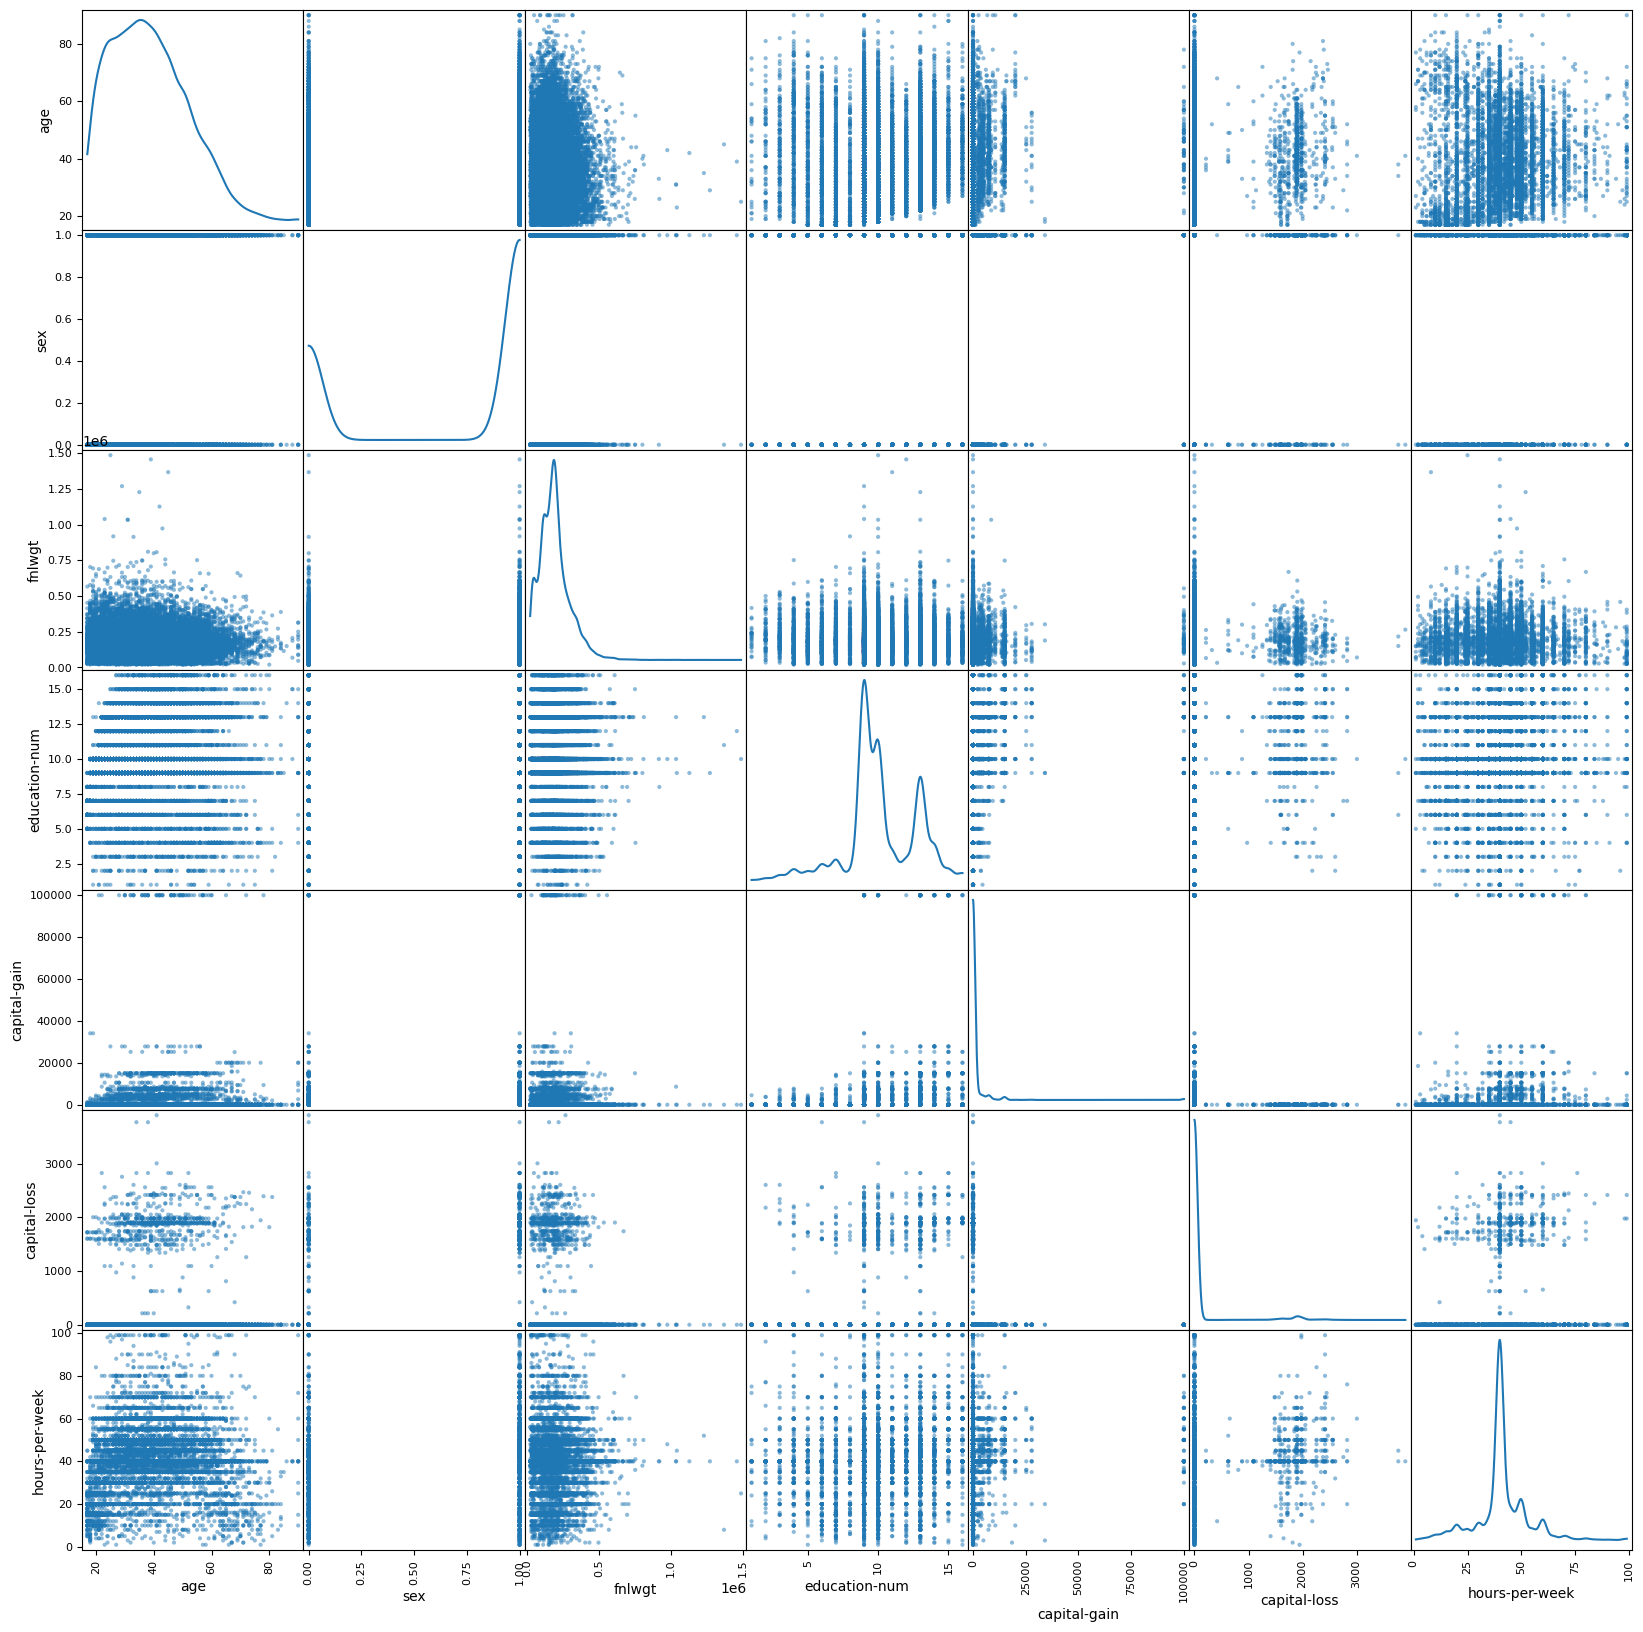

In [19]:
pd.plotting.scatter_matrix(data_adult[num], figsize=(20,20),diagonal='kde')
plt.show()

Для определения порядка нужно знать минимальное и максимальное значение каждого признака. Каждый признак имеет порядок от минимального значения до максимального

In [20]:
data_adult[num].min()

age                  17
sex                   0
fnlwgt            19302
education-num         1
capital-gain          0
capital-loss          0
hours-per-week        1
dtype: int64

In [21]:
data_adult[num].max()

age                    90
sex                     1
fnlwgt            1484705
education-num          16
capital-gain        99999
capital-loss         3900
hours-per-week         99
dtype: int64

Некоторые алгоритмы машинного обучения могут сильно зависеть от масштаба признаков, поэтому разница в шкалах может привести к существенным искажениям результатов.

Алгоритмы машинного обучения, чувствительные к разнице в шкалах признаков, могут существенно улучшить свою производительность с помощью масштабирования данных. К таким относятся линейные модели, метод опорных векторов (SVM), K-средних и KNN.

Деревья решений и нейронные сети не будут зависеть от разницы в шкалах признаков. Масштабирование данных не будет существенно влиять на производительность.

**(1 балл)**
- Масштабируйте данные
- Выделите отдельно X (ваши признаки) и y - ваша колонка таргета

In [22]:
# Отделяем признаки от таргета
X = data_adult
y = target

# Масштабируем признаки
scaler = StandardScaler()
X = scaler.fit_transform(X)

# разбиваем данные на обучающие и тестовые в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Далее будем использовать масштабированные признаки

### 4. Валидация

В нашем случае будем валидироваться с помощью KFold + сохранение баланса классов в каждом "фолде" с помощью StratifiedKFold из sklearn.model_selection

**(1 балл)**

Расскажите:
- Какие виды валидации вы знаете?
- Какие минусы и плюсы каждого подхода к валидации?
- В чем преимущество StratifiedKFold над KFold?

## Какие виды валидации вы знаете?

Существует 5 основных видов кросс-валидации:

* K-fold cross-validation
* Hold-out cross-validation
* Stratified k-fold cross-validation
* Leave-p-out cross-validation
* Leave-one-out cross-validation

Также имеются другие виды валидации:

* Monte Carlo (shuffle-split)
* Time series (rolling cross-validation)

## Какие минусы и плюсы каждого подхода к валидации?

* K-fold cross-validation

Плюсы: Модель имеет низкое смещение. Низкая временная сложность. Весь набор данных используется как для обучения, так и для проверки.

Минусы: Не подходит для несбалансированного набора данных.
* Hold-out cross-validation

Плюсы: Простой, понятный и реализуемый.

Минусы: Не подходит для несбалансированного набора данных. Многие данные изолированы от обучения модели.
* Stratified k-fold cross-validation

Плюсы: Хорошо работает для несбалансированного набора данных.

Минусы: Теперь подходит для набора данных временных рядов.
* Leave-one-out cross-validation и Leave-p-out cross-validation

Плюсы: Простой, понятный и реализуемый.

Минусы: Модель может привести к низкому смещению. Время вычислений велико.

## В чем преимущество StratifiedKFold над KFold?

StratifiedKFold может работать при несбалансированном наборе данных по сравнению с KFold.

### 5. Выбор алгоритма и оптимизация

При подборе алгоритма будем варьировать не один параметр, а несколько в каждом алгоритме.

Выберем 3 алгоритма:

 - kNN (подробнее [здесь](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html))
 - SGD Linear Classifier (подробнее [здесь](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html))
 - RandomForest (подробнее [здесь](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))
 

### 5.1 kNN

**(3 балла)**
- Инициализируйте дефолтную модель (модель с дефолтными гиперпараметрами).
- Инициализируйте GridSearchCV для подбора гиперпараметров (подробнее [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)). Не забудьте задать параметр cv (число фолдов выберите из диапазона от 3 до 10). 
- Подберите наилучшие параметры для модели с помощью GridSearchCV.
- Постройте график зависимости качества ROC_AUC от параметров (получается 2 графика) с доверительным интервалом. Ось Х - значения параметра, ось Y - значения ROC_AUC.

Подберите оптимальные параметры:
- Число соседей (**n_neighbors**) Перебирайте в диапазоне от 0 до 50.
- Метрика (**metric**) Перебирайте из \['minkowski', 'euclidean', 'chebyshev', 'manhattan'\].

Если подбор занимает очень много времени:
* Задайте значение параметра n_jobs=-1.
* Перебирайте значения из диапазона с шагом 2-5.

Для построения графика зависимости качества модели от показателя metric по оси идут 4 категории метрики. Для построения подобного графика, используйте xticks из pylab. Подробнее [здесь](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xticks.html) Потыкайте на картиночки, там откроется код.

Чтобы взять лучшую модель из GridSearchCV используйте метод gsCV.best_estimator_ после того, как обучите GridSearchCV на подбор лучших гиперпараметров.

gsCV.best_estimator_ вернет модель с наилучшими гиперпараметрами с точки зрения качества roc_auc на кросс-валидации.

Чтобы посмотреть параметры лучшей модели, используйте gsCV.best_params_

Обучим модель KNeighborsClassifier

In [23]:
# Инициализируем дефолтную модель
x_kNN = KNeighborsClassifier()

# Инициализируем метрики
xTicks = ['minkowski', 'euclidean', 'chebyshev', 'manhattan']

# Подберём оптимальные параметры. Число соседей будем перебирать из диапазона от 1 до 51, чтобы избежать значений NaN
param_grid = {'n_neighbors': range(1, 51, 2), 'metric': xTicks}

# Подберём наилучшие параметры для модели с помощью GridSearchCV. Для увеличения производительности значение n_jobs будет 
# равно -1. Число фолдов будет равно 3
gsCV1 = GridSearchCV(x_kNN, param_grid, scoring='roc_auc', cv=3, n_jobs=-1)

# Обучим нашу модель
gsCV1.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'euclidean', 'chebyshev',
                                    'manhattan'],
                         'n_neighbors': range(1, 51, 2)},
             scoring='roc_auc')

In [24]:
# Выведем на экран значения наилучших параметров
best_params_knn = gsCV1.best_params_
best_params_knn

{'metric': 'manhattan', 'n_neighbors': 49}

In [25]:
# Выведем на экран точность модели
gsCV1.score(X_test,y_test)

0.8781581017187827

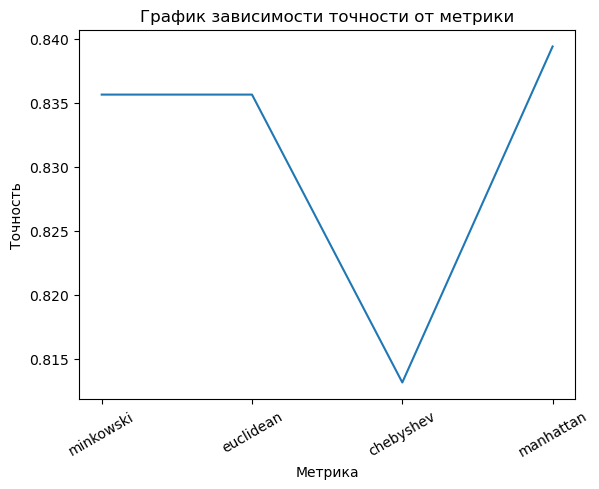

In [26]:
# Получим значения точности для каждой метрики
metric_scores = []
for metric in xTicks:
    knn = KNeighborsClassifier(metric=metric)
    scores = cross_val_score(knn, X_train, y_train, scoring='roc_auc', cv=3)
    metric_scores.append(scores.mean())

# Построим график зависимости точности от метрики
pl.plot(xTicks, metric_scores)
pl.xlabel('Метрика')
pl.ylabel('Точность')
pl.title('График зависимости точности от метрики')
pl.xticks(range(len(xTicks)), xTicks, rotation=30)
pl.show()

Построим график зависимости точности от количества ближайших соседей для четырёх метрик. На графике изображены 4 кривые roc_auc (от 0 до 25, от 26 до 50, от 51 до 75, от 76 до 100) с доверительным интервалом std_test_score

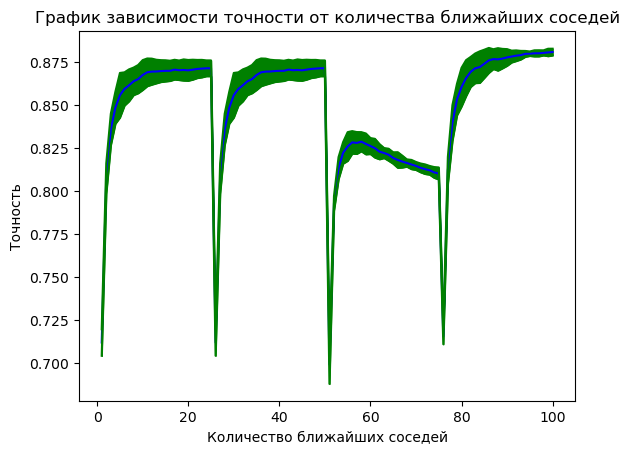

In [27]:
means = gsCV1.cv_results_['mean_test_score']
stds = gsCV1.cv_results_['std_test_score']
error = 1.95 * stds

pl.plot(range(1, len(means) + 1), means, color = 'blue')
pl.plot(range(1, len(means) + 1), means - error, color = 'green')
pl.plot(range(1, len(means) + 1), means + error, color = 'green')
pl.fill_between(range(1, len(means) + 1), means - error, means + error, color = 'green')
pl.xlabel('Количество ближайших соседей')
pl.ylabel('Точность')
pl.title('График зависимости точности от количества ближайших соседей')
pl.show()

### 5.2 SGD Linear Classifier

**(3 балла)**
- Инициализируйте дефолтную модель (модель с дефолтными гиперпараметрами)
- Инициализируйте GridSearchCV для подбора гиперпараметров (подробнее [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)). Не забудьте задать параметр cv (число фолдов выберите из диапазона от 3 до 10). 
- Подберите наилучшие параметры для модели с помощью GridSearchCV.
- Постройте график зависимости качества ROC_AUC от параметров (получается 2 графика) с доверительным интервалом. Ось Х - значения параметра, ось Y - значения ROC_AUC.

Подберите оптимальные параметры:
- Loss функция (**loss**) Перебирайте из \['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive'\]
- Вид штрафа (**penalty**) Перебирайте из \['none', 'l2', 'l1', 'elasticnet'\]


Для построения графика зависимости качества модели от показателей loss, penalty по оси "x" идут категории. Для построения подобного графика, используйте xticks из pylab. Подробнее [здесь](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xticks.html) Потыкайте на картиночки, там откроется код.

Чтобы взять лучшую модель из GridSearchCV используйте метод gsCV.best_estimator_ после того, как обучите GridSearchCV на подбор лучших гиперпараметров.

gsCV.best_estimator_ вернет модель с наилучшими гиперпараметрами с точки зрения качества roc_auc на кросс-валидации.

Чтобы посмотреть параметры лучшей модели, используйте gsCV.best_params_

Обучим модель SGDClassifier

In [28]:
# Инициализируем дефолтную модель
x_SGD = SGDClassifier()

# Инициализируем метрики
xTicks = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', \
          'epsilon_insensitive','none', 'l2', 'l1', 'elasticnet']

# Подберём оптимальные параметры
param_grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', \
                       'epsilon_insensitive'], 'penalty': ['none', 'l2', 'l1', 'elasticnet']}

# Подберём наилучшие параметры для модели с помощью GridSearchCV. Число фолдов будет равно 3
gsCV2 = GridSearchCV(x_SGD, param_grid, scoring='roc_auc', cv=3)

# Обучим нашу модель
gsCV2.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SGDClassifier(),
             param_grid={'loss': ['hinge', 'log', 'modified_huber',
                                  'squared_hinge', 'perceptron', 'squared_loss',
                                  'huber', 'epsilon_insensitive'],
                         'penalty': ['none', 'l2', 'l1', 'elasticnet']},
             scoring='roc_auc')

In [29]:
# Выведем на экран значения наилучших параметров
best_params_SGD = gsCV2.best_params_
best_params_SGD

{'loss': 'log', 'penalty': 'elasticnet'}

In [30]:
# Выведем на экран точность модели
gsCV2.score(X_test,y_test)

0.8965755805403671

Построим график зависимости точности от метрики

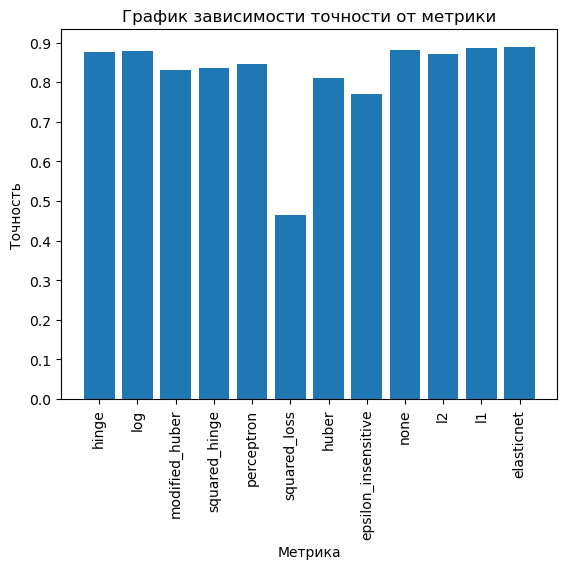

In [31]:
# Для начала посчитаем скор для каждой метрики и объединим значения в одну переменную
metric_scores = []
metric_scores_2 = []

for loss in xTicks:
    sgd = SGDClassifier(loss=loss)
    scores = cross_val_score(sgd, X_train, y_train, scoring='roc_auc', cv=3)
    metric_scores.append(scores.mean())
    
for penalty in xTicks:
    sgd = SGDClassifier(penalty=penalty)
    scores = cross_val_score(sgd, X_train, y_train, scoring='roc_auc', cv=3)
    metric_scores_2.append(scores.mean())
    
metric_scores = metric_scores + metric_scores_2
metric_scores = [x for x in metric_scores if (math.isnan(x) == False)]

# Построим график
pl.bar(xTicks, metric_scores)
pl.xlabel('Метрика')
pl.ylabel('Точность')
pl.title('График зависимости точности от метрики')
pl.xticks(range(len(xTicks)), xTicks, rotation=90)
pl.yticks(np.arange(0, 1, 0.1))
pl.show()

Построим график точности для каждой пары значений loss и penalty с доверительным интервалом

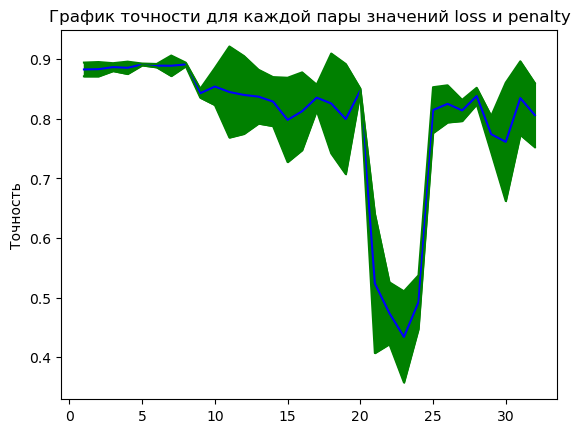

In [32]:
means = gsCV2.cv_results_['mean_test_score']
stds = gsCV2.cv_results_['std_test_score']
error = 1.95 * stds

pl.plot(range(1, len(means) + 1), means, color = 'blue')
pl.plot(range(1, len(means) + 1), means - error, color = 'green')
pl.plot(range(1, len(means) + 1), means + error, color = 'green')
pl.fill_between(range(1, len(means) + 1), means - error, means + error, color = 'green')
pl.ylabel('Точность')
pl.title('График точности для каждой пары значений loss и penalty')
pl.show()

### 5.3 RandomForestClassifier

**(3 балла)**
- Инициализируйте дефолтную модель (модель с дефолтными гиперпараметрами).
- Инициализируйте GridSearchCV для подбора гиперпараметров (подробнее [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)). Не забудьте задать параметр cv (число фолдов выберите из диапазона от 3 до 10). 
- Подберите наилучшие параметры для модели с помощью GridSearchCV.
- Постройте график зависимости качества ROC_AUC от параметров (получается 2 графика) с доверительным интервалом. Ось Х - значения параметра, ось Y - значения ROC_AUC.

Подберите оптимальные параметры:
- Число деревьев (**n_estimators**) Перебирайте в диапазоне от 0 до 100
- Параметр максимального количества фичей для построения дерева (**max_features**) Перебирайте из \['auto', 'sqrt', 'log2', None\]
- Критерий разбиения на поддеревья (**criterion**) Перебирайте из \['gini', 'entropy'\]


Для построения графика зависимости качества модели от показателей max_features, criterion по оси "x" идут категории. Для построения подобного графика, используйте xticks из pylab. Подробнее [здесь](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xticks.html) Потыкайте на картиночки, там откроется код.

Чтобы взять лучшую модель из GridSearchCV используйте метод gsCV.best_estimator_ после того, как обучите GridSearchCV на подбор лучших гиперпараметров.

gsCV.best_estimator_ вернет модель с наилучшими гиперпараметрами с точки зрения качества roc_auc на кросс-валидации.

Чтобы посмотреть параметры лучшей модели, используйте gsCV.best_params_

#### Важно!!!

Число деревьев (**n_estimators**) перебирать с помощью GridSearchCV НЕ НАДО!

Если задание ниже не получится (можете по-старинке перебирать (но придется долго ждать))

**(2 балла)**

Подберём число деревьев (n_estimators) в алгоритме RandomForest, начиная с которого качество стабилизируется. Выполните задание одним из предложенных способов (можете сделать двумя, а потом сравнить их результаты).

_Способ 1_
1. Разбейте выборку на обучающую и тестовую с помощью train_test_split.
2. Для каждого числа деревьев:
  - Обучите модель на обучающей выборке
  - Посчитайте скор на тестовой выборке
  - Сохраните скор
3. Проанализируйте зависимость качества предсказания модели от числа деревьев (постройте график).
4. Напишите какое оптимальное количество деревьев следует использовать и почему.

_Способ 2_
1. Для каждого числа деревьев:
  - Посчитайте скор, используя cross_val_score
  - Сохраните скор
3. Проанализируйте зависимость качества предсказания модели от числа деревьев (постройте график).
4. Напишите какое оптимальное количество деревьев следует использовать и почему.

В дальнейших экспериментах используйте подобранное количество деревьев.

#### Сначала подберите оптимальное количество деревьев, зафиксируйте, затем другие параметры.

In [33]:
max_trees_number = 100
result = []
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42) # для способа 1

# Подсказка
for current_trees_number in range(1,max_trees_number + 1):
    # инициализируем модель
    RFC_model = RandomForestClassifier(n_estimators=current_trees_number)
    # обучаем модель
    RFC_model.fit(X_train, y_train)
    # считаем скор
    score = RFC_model.score(X_test, y_test)
    # сохраняем скор
    result.append(score)

Проанализируем зависимость качества предсказания модели от числа деревьев и построим график

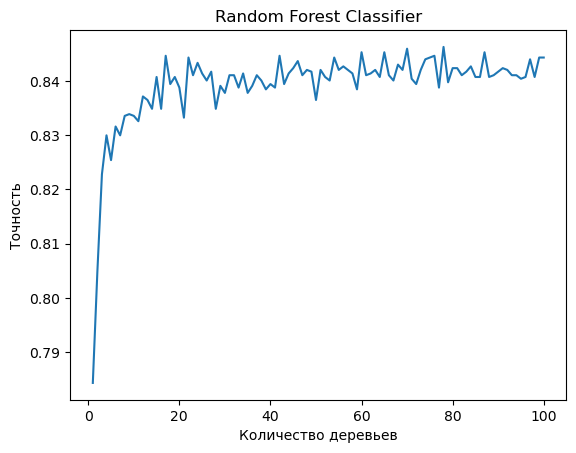

In [34]:
plt.plot(range(1,max_trees_number + 1), result)
plt.xlabel('Количество деревьев')
plt.ylabel('Точность')
plt.title('Random Forest Classifier')
plt.show()

Будем использовать количество деревьев, равное точности первого околомаксимального скачка на графике, чтобы избежать переобучения. Данный скачок зафиксирован у количества деревьев, равного 20

In [35]:
# максимальный скор
max(result)

0.8462540716612378

Для более точного определения количества деревьев выведем скор значения

In [36]:
result

[0.7843648208469055,
 0.8048859934853421,
 0.8228013029315961,
 0.8299674267100977,
 0.8254071661237785,
 0.8315960912052117,
 0.8299674267100977,
 0.8335504885993485,
 0.8338762214983714,
 0.8335504885993485,
 0.8325732899022801,
 0.8371335504885994,
 0.8364820846905537,
 0.8348534201954397,
 0.8407166123778501,
 0.8348534201954397,
 0.8446254071661238,
 0.8394136807817589,
 0.8407166123778501,
 0.8387622149837134,
 0.8332247557003257,
 0.844299674267101,
 0.8410423452768729,
 0.8433224755700326,
 0.8413680781758958,
 0.8400651465798046,
 0.8416938110749186,
 0.8348534201954397,
 0.8390879478827361,
 0.8377850162866449,
 0.8410423452768729,
 0.8410423452768729,
 0.8387622149837134,
 0.8413680781758958,
 0.8377850162866449,
 0.8390879478827361,
 0.8410423452768729,
 0.8400651465798046,
 0.8384364820846906,
 0.8394136807817589,
 0.8387622149837134,
 0.8446254071661238,
 0.8394136807817589,
 0.8413680781758958,
 0.8423452768729641,
 0.8436482084690554,
 0.8410423452768729,
 0.84201954397

In [37]:
result[16]

0.8446254071661238

Околомаксимальный скачок зафиксирован при количестве деревьев = 16, поэтому будем использовать данное значение. Далее обучим модель RandomForestClassifier

In [38]:
# Инициализируем дефолтную модель
x_RFC = RandomForestClassifier()

# Инициализируем метрики
xTicks = ['auto', 'sqrt', 'log2', None, 'gini', 'entropy']

# Подберём оптимальные параметры
param_grid = {'n_estimators': [16], 'max_features': ['auto', 'sqrt', 'log2', None], 'criterion': ['gini', 'entropy']}

# Подберём наилучшие параметры для модели с помощью GridSearchCV. Число фолдов будет равно 3
gsCV3 = GridSearchCV(x_RFC, param_grid, scoring='roc_auc', cv=3)

# Обучим нашу модель
gsCV3.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [16]},
             scoring='roc_auc')

In [39]:
# Выведем на экран значения наилучших параметров
best_params_RFC = gsCV3.best_params_
best_params_RFC

{'criterion': 'entropy', 'max_features': None, 'n_estimators': 16}

In [40]:
# Выведем на экран точность модели
gsCV3.score(X_test,y_test)

0.8904406915237318

Построим график зависимости точности от метрики

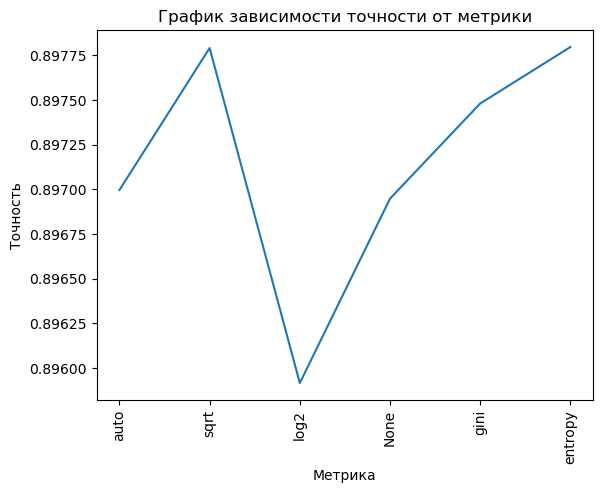

In [41]:
# Для начала посчитаем скор для каждой метрики и объединим значения в одну переменную

metric_scores = []
metric_scores_2 = []

for max_features in xTicks:
    rfc = RandomForestClassifier(max_features=max_features)
    scores = cross_val_score(rfc, X_train, y_train, scoring='roc_auc', cv=3)
    metric_scores.append(scores.mean())
    
for criterion in xTicks:
    rfc = RandomForestClassifier(criterion=criterion)
    scores = cross_val_score(rfc, X_train, y_train, scoring='roc_auc', cv=3)
    metric_scores_2.append(scores.mean())
    
xTicks[3] = 'None'
    
metric_scores = metric_scores + metric_scores_2
metric_scores = [x for x in metric_scores if (math.isnan(x) == False)]

# Построим график
pl.plot(xTicks, metric_scores)
pl.xlabel('Метрика')
pl.ylabel('Точность')
pl.title('График зависимости точности от метрики')
pl.xticks(range(len(xTicks)), xTicks, rotation=90)
pl.show()

Построим график точности для каждой пары значений max_features и criterion с доверительным интервалом

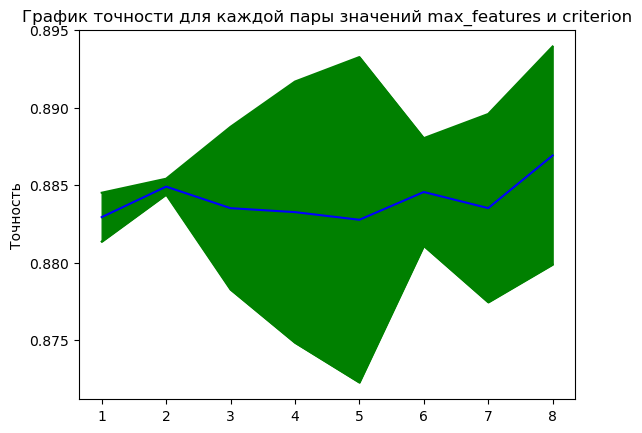

In [42]:
means = gsCV3.cv_results_['mean_test_score']
stds = gsCV3.cv_results_['std_test_score']
error = 1.95 * stds

pl.plot(range(1, len(means) + 1), means, color = 'blue')
pl.plot(range(1, len(means) + 1), means - error, color = 'green')
pl.plot(range(1, len(means) + 1), means + error, color = 'green')
pl.fill_between(range(1, len(means) + 1), means - error, means + error, color = 'green')
pl.ylabel('Точность')
pl.title('График точности для каждой пары значений max_features и criterion')
pl.show()

### 6. Ансамбль моделей

**(2 балла)**

Попробуйте "заблендить" модели (сложить результаты (ответы) разных алгоритмов) с разными коэффициентами перед ними.

Попробуйте различные комбинации алгоритмов. А так же все три алгоритма вместе.

$$result(x) = clf_1(x) * \alpha + clf_2(x) * (1 - \alpha)$$

Подробнее про ансамбли: [здесь](https://dyakonov.org/2017/03/10/cтекинг-stacking-и-блендинг-blending/)

Простой пример использования VotingClassifier и его описание можно найти в официальной документации: [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) 


Подберём наилучшие веса для ансамбля KNN и SGD

In [44]:
# Запускаем поиск лучших параметров alpha_1, alpha_2 на кроссвалидации
knn_sgd = GridSearchCV(estimator=VotingClassifier(estimators=[('KNN', gsCV1.best_estimator_), 
                                                              ('SGD', gsCV2.best_estimator_)], voting='soft'),
                       param_grid={'weights': [[i, 1 - i] for i in np.arange(0,1.1,0.1)]},
                       cv=StratifiedKFold(shuffle=True, n_splits=10),
                       scoring='roc_auc')
knn_sgd.fit(X_train, y_train)
knn_sgd.best_params_

{'weights': [0.5, 0.5]}

Посчитаем скор на наилучших весах для ансамбля KNN и SGD

In [45]:
knn_sgd = GridSearchCV(estimator=VotingClassifier(estimators=[('KNN', gsCV1.best_estimator_), 
                                                              ('SGD', gsCV2.best_estimator_)], voting='soft'),
                       param_grid={'weights': [[0.5,0.5]]},
                       cv=StratifiedKFold(shuffle=True, n_splits=10),
                       scoring='roc_auc')
knn_sgd.fit(X_train, y_train)
knn_sgd.score(X_test,y_test)

0.9025948850951191

Подберём наилучшие веса для ансамбля RFC и SGD

In [46]:
# Запускаем поиск лучших параметров alpha_1, alpha_2 на кроссвалидации
rfc_sgd = GridSearchCV(estimator=VotingClassifier(estimators=[('SGD', gsCV2.best_estimator_), 
                                                              ('RFC', gsCV3.best_estimator_)], voting='soft'),
                    param_grid={'weights': [[i, 1 - i] for i in np.arange(0,1.1,0.1)]},
                    cv=StratifiedKFold(shuffle=True, n_splits=10),
                    scoring='roc_auc')
rfc_sgd.fit(X_train, y_train)
rfc_sgd.best_params_

{'weights': [0.5, 0.5]}

Посчитаем скор на наилучших весах для ансамбля RFC и SGD

In [47]:
rfc_sgd = GridSearchCV(estimator=VotingClassifier(estimators=[('SGD', gsCV2.best_estimator_), 
                                                              ('RFC', gsCV3.best_estimator_)], voting='soft'),
                       param_grid={'weights': [[0.5, 0.5]]},
                       cv=StratifiedKFold(shuffle=True, n_splits=10),
                       scoring='roc_auc')
rfc_sgd.fit(X_train, y_train)
rfc_sgd.score(X_test,y_test)

0.9112060667638133

Подберём наилучшие веса для ансамбля RFC и KNN

In [48]:
# Запускаем поиск лучших параметров alpha_1, alpha_2 на кроссвалидации
knn_rfc = GridSearchCV(estimator=VotingClassifier(estimators=[('KNN', gsCV1.best_estimator_), 
                                                              ('RFC', gsCV3.best_estimator_)], voting='soft'),
                       param_grid={'weights': [[i, 1 - i] for i in np.arange(0,1.1,0.1)]},
                       cv=StratifiedKFold(shuffle=True, n_splits=10),
                       scoring='roc_auc')
knn_rfc.fit(X_train, y_train)
knn_rfc.best_params_

{'weights': [0.5, 0.5]}

Посчитаем скор на наилучших весах для ансамбля RFC и KNN

In [49]:
knn_rfc = GridSearchCV(estimator=VotingClassifier(estimators=[('KNN', gsCV1.best_estimator_), 
                                                              ('RFC', gsCV3.best_estimator_)], voting='soft'),
                    param_grid={'weights': [[0.5, 0.5]]},
                    cv=StratifiedKFold(shuffle=True, n_splits=10),
                    scoring='roc_auc')
knn_rfc.fit(X_train, y_train)
knn_rfc.score(X_test,y_test)

0.9050954087066573

Подберём наилучшие веса для ансамбля SGD, RFC и KNN

In [50]:
# Запускаем поиск лучших параметров alpha_1, alpha_2, alpha_3  на кроссвалидации
knn_rfc_sgd = GridSearchCV(estimator=VotingClassifier(estimators=[('KNN', gsCV1.best_estimator_), 
                                                                  ('SGD', gsCV2.best_estimator_), 
                                                                  ('RFC', gsCV3.best_estimator_)], voting='soft'),
                           param_grid={'weights': [[i,j, 1-i-j] for i in np.arange(0,1.1,0.1) for j in np.arange(0,1.1-i,0.1)]},
                           cv=StratifiedKFold(shuffle=True, n_splits=10),
                           scoring='roc_auc')
knn_rfc_sgd.fit(X_train, y_train)
knn_rfc_sgd.best_params_

{'weights': [0.30000000000000004, 0.4, 0.29999999999999993]}

Посчитаем скор на наилучших весах для ансамбля SGD, RFC и KNN

In [51]:
knn_rfc_sgd = GridSearchCV(estimator=VotingClassifier(estimators=[('KNN', gsCV1.best_estimator_), 
                                                                  ('SGD', gsCV2.best_estimator_), 
                                                                  ('RFC', gsCV3.best_estimator_)], voting='soft'),
                           param_grid={'weights': [[0.3, 0.4, 0.3]]},
                           cv=StratifiedKFold(shuffle=True, n_splits=10),
                           scoring='roc_auc')
knn_rfc_sgd.fit(X_train, y_train)
knn_rfc_sgd.score(X_test,y_test)

0.9088191779967291

Лучшую точность показал ансамбль RFC и SGD. Данную модель будем использовать для дальнейших вычислений

### 7. Ящик с усами

**(2 балла)**

Посмотрим визуально на качество наших моделей. Мы уже знаем, какие гиперпараметры для наших моделей являются наилучшими. Зафиксируем данные параметры:

In [56]:
best_model_knn = KNeighborsClassifier(best_params_knn) 
best_model_sgd = SGDClassifier(best_params_SGD)  
best_model_random_forest = RandomForestClassifier(best_params_RFC)  
best_model_voting_classifier = rfc_sgd.best_params_

Посмотрим на наше качество на кросс_валидации:

In [60]:
# В качестве cv возьмём StratifiedKFold с 7 фолдами
cv_score_knn = cross_val_score(estimator=gsCV1, X=X, y=y, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
cv_score_sgd = cross_val_score(estimator=gsCV2, X=X, y=y, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
cv_score_random_forest = cross_val_score(estimator=gsCV3, X=X, y=y, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')
cv_score_voting_classifier = cross_val_score(estimator=rfc_sgd, X=X, y=y, cv=StratifiedKFold(n_splits=7), scoring='roc_auc')

Создадим таблицу pandas.DataFrame с колонками названиями методов (4 колонки), а значения - выход функции cross_val_score

In [61]:
final_result = pd.DataFrame({'KNN': cv_score_knn, 'SGD': cv_score_sgd, 'RFC': cv_score_random_forest, 'VC': cv_score_voting_classifier})
final_result

,KNN,SGD,RFC,VC
0,0.872693,0.889771,0.880568,0.904245
1,0.884734,0.901526,0.895382,0.909364
2,0.897125,0.900750,0.894052,0.915282
3,0.877480,0.894921,0.883528,0.905174
4,0.880364,0.898495,0.887598,0.903622
5,0.883567,0.885268,0.882737,0.906282
6,0.871353,0.897632,0.886360,0.904610


Посмотрим распределение на боксплотах

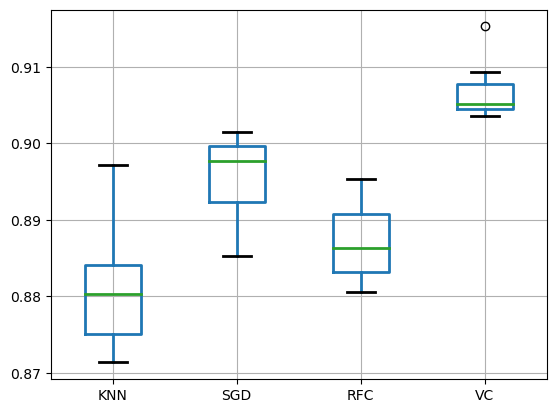

In [62]:
ax = final_result.boxplot() 
_ = plt.setp(ax.lines, linewidth=2.0)
plt.show()

Качество на кросс_валидации у ансамбля выше, чем качество отдельной модели

### 8. Выводы

**(1 балл)**
По графику выше сделайте вывод:
- Какой алгоритм "победил в соревновании" за качество?
- Лучший алгоритм с точки зрения качества/скорости работы (иногда это очень важно)
- Опишите каждый алгоритм (вкратце), его плюсы и минусы

_____

Среди алгоритмов KNN, SGD Linear Classifier и RandomForestClassifier (если не учитывать ансамбль, который показал наилучшую точность) в соревновании за качество победил авлгоритм SGD Linear Classifier. RFC мог бы победить в борьбе за качество при обучении на количестве деревьев, дающем максимальный скор, но была высока вероятность переобучения

_____

Лучшим алгоритмом с точки зрения качества/скорости работы является SGD Linear Classifier, так как для ускорения работы KNN значение n_jobs было равно -1 и количество соседей перебиралось с шагом 2, а для Random Forest Classifier сначало было посчитано оптимальное количество деревьев

_____

* KNN (k-ближайших соседей) - это алгоритм, основанный на близости объектов друг к другу. Он относит объект к тому классу, к которому принадлежит большинство из его k ближайших соседей. 

    Плюсы: простота реализации, показывает хорошее качество на линейно неразделимых классах. 

    Минусы: сложность классификации для большой выборки, требует подбора числа соседей k, не работает на разреженных данных.
    

* SGD Linear Classifier (линейный классификатор с градиентным спуском) - это алгоритм машинного обучения, основанный на градиентном спуске. Он использует линейную функцию для классификации объектов. 

    Плюсы: быстро обучается на больших данных, хорошо работает на разреженных данных. 

    Минусы: чувствительность к масштабу данных, требуется подбор оптимальных параметров.
    

* RandomForestClassifier (случайный лес) - это ансамблевый алгоритм, который использует несколько деревьев решений для классификации объектов. 

    Плюсы: работает на большом количестве объектов, устойчив к шуму и выбросам, позволяет оценить важность признаков. 

    Минусы: высокая вычислительная сложность, не устойчив к переобучению, трудность интерпретации.

_____